# Electrochemical reduction of carbon dioxide in bicarbonate buffer solutions
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

Solves **2D time independent** and **2D time dependent** reaction-diffusion equations for CO<sub>2</sub>-bicarbonate-carbonate-hydroxide system. This is accomplished by extending the 1D solution published by Gattrell and co-workers into 2D and using a finite element solver.   
>Gupta, N.; Gattrell, M.; MacDougall, B. Calculation for the Cathode Surface Concentrations in the Electrochemical Reduction of CO<sub>2</sub> in KHCO<sub>3</sub> Solutions. [J. Appl. Electrochem. **2006**, *36*, 161–172](http://link.springer.com/10.1007/s10800-005-9058-y).

**Overview**
* Look in notebook `1D CO2 reaction diffusion-SciPy.ipynb` for steady state 1D solution obtained using `solve_bvp` from `SciPy`  
* Here, the time dependent **and** time independent  solutions are obtained using the finite element method as implemented in [FEniCS](https://fenicsproject.org/)  
* The problem is a coupled, non-linear system of 4 reaction-diffusion PDEs with Dirichlet boundary condition at the boundary with the bulk electrolyte and Neumann boundary conditions at the electrode surface.  
* In this notebook, the domain is a simple rectangular mesh generated with `FEniCS`. However, more complex geometries could be designed and meshed with [GMSH](https://gmsh.info/). There is a utility in the `meshio` package which can convert `.msh` files to `.xdmf` files which `FEniCS` can import.   

**Notes on installing FEniCS**  
* Code developed using WSL (Windows Linux Subsystem) using a dedicated `conda` environment for `FEniCS`  
* `FEnicS` also install and runs under MacOS using `conda`  
* Was not able to use `FEniCS` natively under Windows

**Notes on coding the weak form**  

A general reaction-diffusion-advection problem for species $u_i$ would be 

$$\frac{\partial u_1}{\partial t} =  -\vec{w} \cdot \nabla u_1 + \nabla \cdot(D_1 \nabla u_1) +  g_1(u) + f_1(u,t)$$ 

where 

> $u_1$ is concentration of the species, function of position and time  
>$\vec{w} \cdot \nabla u_1$ term is for advection (as in a laminar flow)   
> $\nabla \cdot D_1 \nabla$ term is for diffusion   
> $g_1$ is generation term for $u_1$ as a result of chemical reactions and, in general, depends on the concentration of not only $u_1$ but the other species $u_2$, $u_3$, etc. This term makes the problem non-linear.  
> $f_1$ is a source/sink for $u_1$ acting at the boundaries (as in Neumman boundary conditions) or internally and can be a function of time. 

Moving all terms to LHS and using backwards Euler for the time derivative yields (sort of) the variational form:

$$ \int_{\Omega} \left[ \frac{u^{n+1}-u^n}{\Delta t} v_1 +  D_1 \nabla u_1 \cdot \nabla v_1 + (\vec{w} \cdot \nabla u_1)
v_1-  g_1 v_1  -  f_1^{n+1} v_1 \right]  dx = 0$$

where the Neumann BC sources are integrated over a surface. Note that written this way, the diffusion term is positive, and the generation terms are negative. And all the second derivatives are gone. In this form, it relatively straightfoward to code the terms for the `dolfin` solver used by `FEniCS`.

# Import packages, units, constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fenics import *

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from units import *
from CO2parameters import *   

Values below roughly correspond to those obtained on "oxide-derived" Cu at -1.0 vs. RHE (current density ~ 12 mA cm$^{-2}$):
> Lum, Y.; Yue, B.; Lobaccaro, P.; Bell, A. T.; Ager, J. W. Optimizing C–C Coupling on Oxide-Derived Copper Catalysts for Electrochemical CO 2 Reduction. [J. Phys. Chem. C 2017, 121, 14191–14203](http://pubs.acs.org/doi/abs/10.1021/acs.jpcc.7b03673).

In [2]:
# Optionally can overwrite FE values here
FEmethane      = 0.05
FEethylene     = 0.65             # ethanol requires same number of electrons per CO2
FECO           = 0.05
FEformate      = 0.00
FEH2           = 0.25

# Bulk equilibria
$$\require{mhchem}$$
As a first step one needs to solve for the bulk concentrations of bicarbonate and carbonate and for the pH for a given concentation of dissolved CO<sub>2</sub> and carbonate buffer concentration (e.g. KCO<sub>3</sub>, CsCO<sub>3</sub>, etc.)

CO<sub>2</sub>-bicarbonate-carbonate equations for acidic conditions:

$$\ce{CO2{(aq)} +H2O <=> HCO3- + H+}\tag{1a}$$
$$\ce{HCO3- + H2O  <=> CO3^2- + H+}\tag{2a}$$

Equivalently, and suitable for pH > 7, we can write them in the base form:

$$\ce{CO2{(aq)} + OH- <=> HCO3- }\tag{1b}$$
$$\ce{HCO3- + OH-  <=> CO3^2- + H2O}\tag{2b}$$

For this problem there 3 unknowns. The three equations used to solve for them are either the acid or base equilibria above (two equations) plus the charge balance, written here for KHCO<sub>3</sub> buffer. 

$$ [\ce{H+}] + [\ce{K+}] = [\ce{OH-}] + [\ce{HCO3-}] + 2~[\ce{CO3^2-}] $$

Values for the equilibrium constants are in `CO2parameters.py`

**Programming notes**  

The root finder `fsolve` (same name as in Matlab) requires more help to solve the equations compared to *Mathematica*. For example, I have not yet been able to figure out how to constrain the solutions to positive values. And it needs guesses to work properly. Here, guesses are generated by fitting splines between solutions at a number of buffer concentrations.  
> As a result, at present, the solver will only work for ~33 mm CO<sub>2</sub> (saturation condition for 1 atm) and between 10 and 1000 mM buffer.  

Values for the equilibrium constants and the rate constants are in the file [CO2parameters.py](CO2parameters.py), which is loaded at the begining of the notebook. The FEs for the cathode reactions are specified there as well. Note that one can overwrite the FEs, see below. 

In [3]:
# For troubleshoooting
# Correct answers for 33 mM and 100 mM buffer from Mathematica solver
# Slightly different values for K1 and K2 used.  
HplusCorrect=    1.4034e-7*molar;
OHminusCorrect = 7.1254e-8*molar;
HCO3correct =    9.9933e-2*molar;
CO3correct =     3.3397e-5*molar;

In [4]:
CO2bulk = 33.4*mM           # Calculated from Henry's law for 1 atm CO2
buffer = 100*mM             # Change this value to get different buffer pH

# Written this way it is the acid equation. 
# So K1a and K2a from the GGM paper are used.

# Taking the log for the equilibria helped with convergence
def CO2equations(x):
    Hplus, HCO3, CO3 = x
    return (np.log10(Hplus) + np.log10(HCO3) - np.log10(CO2bulk) - np.log10(K1a), \
            np.log10(Hplus)+ np.log10(CO3) - np.log10(HCO3) - np.log10(K2a), \
            Hplus + buffer - Kw/Hplus - HCO3 - 2* CO3 )

# Guesses - these are crucial. Guesses is a python tuple
# This section required more work to handle bulk pH near the pKa of carbonate

pHguess=interp1d([10,50,100,200,300,500,1000,1500],\
                 [5.85,6.55,6.85,7.15, 7.32,7.55, 7.85, 8.02], kind='cubic')
logCO3guess=interp1d([10,50,100,200,300,500,1000,1500],\
                 [-3.48148606, -2.078076083, -1.477555766, -0.876148359, \
                  -0.524328812, -0.080921908, 0.51851394,  3.171726454], kind='cubic')

guesses = (10**(-pHguess(buffer/mM).item(0))*molar,\
           np.abs(buffer-2*10**(logCO3guess(buffer/mM).item(0))*mM), \
           10**(logCO3guess(buffer/mM).item(0))*mM)

# Call the solver
HplusBulk, HCO3bulk, CO3bulk =  fsolve(CO2equations, guesses)
OHbulk = Kw/HplusBulk  

print('Concentrations in the bulk')
print(f'CO2 (mM) = {CO2bulk:3.1f}')               # new way to do formatted print in Python 3.8
print(f'buffer (mM)= {buffer/mM:3.1f}')
print()
print (f'pH = {-np.log10(HplusBulk/molar):3.3f}')
print(f'HCO3(mM) = {HCO3bulk/mM:3.2f}')
print(f'CO3(mM) = {CO3bulk/mM:3.4f}')

Concentrations in the bulk
CO2 (mM) = 33.4
buffer (mM)= 100.0

pH = 6.829
HCO3(mM) = 99.94
CO3(mM) = 0.0314


# System of PDEs
Consideration of the forward and reverse rates of reactions (1) and (2) above leads to the following equations for CO<sub>2</sub>, HCO<sub>3</sub><sup>-</sup>, CO<sub>3</sub><sup>2-</sup>, and OH<sup>-</sup> in the diffusion layer as a function of time. 

These 4 simultaneous PDEs need to be solved over [0, *L*], where *L* is the thickness of the diffusion layer (typically 100 microns). 

$$ \frac{\partial [\ce{CO2}]}{\partial t} = D_{\ce{CO2}} \frac{d^2 [\ce{CO2}]}{dx^2} - [\ce{CO2}] [\ce{OH-}] k_{1f} + [\ce{HCO3-}]k_{1r}$$

$$ \frac{\partial [\ce{HCO3-}]}{\partial t}  = D_{\ce{HCO3-}} \frac{d^2 [\ce{HCO3-}]}{dx^2}
+ [\ce{CO2}] [\ce{OH-}] k_{1f} - [\ce{HCO3-}]k_{1r}  
- [\ce{HCO3-}] [\ce{OH-}] k_{2f} + [\ce{CO3^2-}] k_{2r}  $$

$$ \frac{\partial [\ce{CO3^2-}]}{\partial t}  = D_{\ce{CO3^2-}} \frac{d^2 [\ce{CO3^2-}]}{dx^2}
+ [\ce{HCO3-}] [\ce{OH-}] k_{2f} - [\ce{CO3^2-}] k_{2r} $$

$$ \frac{\partial [\ce{OH-}]}{\partial t}  = D_{\ce{OH-}} \frac{d^2 [\ce{OH-}]}{dx^2} 
- [\ce{CO2}] [\ce{OH-}] k_{1f} + [\ce{HCO3-}]k_{1r} 
- [\ce{HCO3-}] [\ce{OH-}] k_{2f}+ [\ce{CO3^2-}] k_{2r}$$

Boundary conditions at *L* are the bulk concentrations from the equilibrium solver above. 

Molar flux boundary conditions for CO<sub>2</sub> and OH<sup>-</sup> determined by the current density *j* and the assumed Faradaic efficiencies.  
For example, for 100% FE for CO, they are:

$$ \textrm{molar flux } \ce{CO2} = D_{\ce{CO2}} \frac {d [\ce{CO2}]}{dx} \bigg\lvert _{x=0} =  \left( \frac{j}{F} \right) \frac{1}{2} $$
$$\textrm{molar flux } \ce{OH-}= -D_{\ce{OH-}} \frac {d [\ce{OH-}]}{dx} \bigg\lvert _{x=0} =  \left( \frac{j}{F} \right)  $$

For this example, two electrons are required to make one CO. The reaction consumes two protons, so two hydroxide ions are produced, assuming that water equilibrium is infinitly fast. Flux boundary conditions for bicarbonate and carbonate are zero. The current density *j* is negative for cathodic currents. 

# Geometry and boundary conditions
*L*, the thickness of the diffusion layer, and the current density *j* are set here  
FE values are loaded in [CO2parameter.py](CO2parameters.py).   
Addition products such as ethanol, acetate, and propanol could be added there.  

In [5]:
L = 100*micron                  # width of diffusion layer. 
jTotal = -12*mA*cm**-2          # Note negative sign for cathodic current

# Flux boundary conditions. 
# In contrast to solve_bvp, do not include the diffusion coefficient. 
# Note dependent on FEs and on z, the number of electrons tranferred to make a given product. 

CO2_molar_flux =  (jTotal/F) * (FEmethane/zMethane    + \
                                FEformate/zFormate    +  \
                                FECO/zCO              +  \
                                2*(FEethylene/zEthylene) )   # 2 for C2 products
                          
g0HCO3  = 0   # no reaction at electrode for bicarbonate
g0CO3   = 0   # no reaction at elecrode for carbonate

OH_molar_flux = -(jTotal/F) * ( 8*(FEmethane/zMethane) + \
                                FEformate/zFormate      + \
                                2*(FECO/zCO)            + \
                                12*(FEethylene/zEthylene) + \
                                2*(FEH2/zH2)) ;   # Added - was missing in GGM

print('**********')
print('Bulk CO2 (mM)    = ' + f'{CO2bulk/mM:3.2f}')
print('Buffer (mM)      = ' + f'{buffer/mM:3.2f}')
print('Bulk pH          = ' + f'{-np.log10(HplusBulk/molar):3.3f}')
print()
print('j (mA cm-2)      = ' + f'{jTotal/(mA*cm**-2):3.2f}')
print()
print(''+'\tCH4'+'\tC2H4'+'\tCO'+'\tformate'+ '\tH2')
print('FE\t'+f'{FEmethane:3.2f}'+'\t'+f'{FEethylene:3.2f}'+'\t'+f'{FECO:3.1f}''\t'+f'{FEformate:3.2f}''\t'+f'{FEH2:3.2f}')
print()


print(f'CO2 molar flux is {CO2_molar_flux/(mol*cm**-2):.2e} mol cm^-2 s^-1')        # positive slope
print(f'OH- molar flux is {OH_molar_flux/(mol*cm**-2):.2e} mol cm^-2 s^-1')         # positive slope
print()
print('With no chemistry CO2 at surface would be {:.3f} mM'.format(
                                                    (CO2bulk + L*DCO2**-1*CO2_molar_flux)/mM))
print('With no chemistry OH- at surface would be {:.3e} molar'.format(
                                                    (OHbulk + L*DOH**-1*OH_molar_flux)/molar))
print('    corresponding to pH {:.3f}'.format(
    np.log10((OHbulk + L*DOH**-1*OH_molar_flux)/molar) + 14))

**********
Bulk CO2 (mM)    = 33.40
Buffer (mM)      = 100.00
Bulk pH          = 6.829

j (mA cm-2)      = -12.00

	CH4	C2H4	CO	formate	H2
FE	0.05	0.65	0.1	0.00	0.25

CO2 molar flux is -1.74e-08 mol cm^-2 s^-1
OH- molar flux is 1.24e-07 mol cm^-2 s^-1

With no chemistry CO2 at surface would be 24.311 mM
With no chemistry OH- at surface would be 2.360e-02 molar
    corresponding to pH 12.373


# Steady state solution
Works well and converges quickly. 

In [6]:
# 1D mesh, evenly spaced
mesh = RectangleMesh(Point(-3*L/2, 0.0), Point(3*L/2, L), 200, 100)  

# Make a function space to hold the 4 scalars which are the solution
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1, P1])
V_hat = FunctionSpace(mesh, element)    # Has subspaces V.sub[0], V.sub[1] etc.

## Set the Dirchlet BCs 
#  Define top boundary.
def top_boundary(x, on_boundary) :
    return on_boundary and near(x[1], L)

# Set values for BCs, bulk concentrations of the 4 species
bc1 = DirichletBC(V_hat.sub(0), CO2bulk, top_boundary)
bc2 = DirichletBC(V_hat.sub(1), HCO3bulk, top_boundary)
bc3 = DirichletBC(V_hat.sub(2), CO3bulk, top_boundary)
bc4 = DirichletBC(V_hat.sub(3), OHbulk, top_boundary)

BCs = [bc1, bc2, bc3, bc4]

# For the Neumann BCs for the electrodes
#  CO2R electrode in the center of the cell, at the bottom
#  Changed to two electrode with a space between them
electrode1 = AutoSubDomain(lambda x: near(x[1], 0.0) 
                            and x[0] > -L and x[0] < -L + 30*micron)
electrode2 = AutoSubDomain(lambda x: near(x[1], 0.0) 
                            and x[0] < L and x[0] > L - 60*micron)

# Set the boundaries function to return 1 for electrode 1, 2 for electrode 2, etc. 
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
boundaries.set_all(0)

# These will be used in the weak form 
electrode1.mark(boundaries, 1)
electrode2.mark(boundaries, 2)
# Important - need this statement
ds = ds(subdomain_data=boundaries) 

#  Set the trial and test functions.
u = Function(V_hat)                # Function not TrialFunction for non-linear problems
#u_new = Function(V_hat)            # scalar, for the next time step
cCO2, cHCO3, cCO3, cOH = split(u)
v1, v2, v3, v4 = TestFunction(V_hat)

# Initial conditions - bulk concentration throughout the domain
u_init = Expression(('CO2bulk','HCO3bulk','CO3bulk','OHbulk'), degree=1,
                   CO2bulk=CO2bulk, HCO3bulk=HCO3bulk, CO3bulk=CO3bulk, OHbulk=OHbulk)
u.interpolate(u_init)

# Define variational problem, use indents to isolate the chemistry
#  First line is time (turned off for steady state) and advection (not used here)
#  Second line is diffusion
#  Third line is chemistry - written as a negative term
#                           inside parens sinks are negative, sources are positive
#  Fourth line is spatial source terms (not used here) and Neumann BCs for each electrode

R1_SS = 0 +    \
     + DCO2*dot(grad(cCO2), grad(v1))*dx \
     - (-k1f*cCO2*cOH + k1r*cHCO3)*v1*dx \
     - CO2_molar_flux*v1*ds(1) - CO2_molar_flux*v1*ds(2)
     
R2_SS = 0+   \
     + DHCO3*dot(grad(cHCO3), grad(v2))*dx \
     - (+k1f*cCO2*cOH - k1r*cHCO3 - k2f*cHCO3*cOH + k2r*cCO3)*v2*dx 

R3_SS = 0+  \
     + DCO3*dot(grad(cCO3), grad(v3))*dx \
     - (+k2f*cHCO3*cOH - k2r*cCO3)*v3*dx 

R4_SS = 0+  \
     + DOH*dot(grad(cOH), grad(v4))*dx \
     - (-k1f*cCO2*cOH + k1r*cHCO3 - k2f*cHCO3*cOH + k2r*cCO3)*v4*dx \
     - OH_molar_flux*v4*ds(1) - OH_molar_flux*v4*ds(2)
     
Eqs_SS = R1_SS + R2_SS + R3_SS + R4_SS   # Add them together for the coupled problem

solve(Eqs_SS == 0, u, BCs, 
          solver_parameters={"newton_solver":           # Send instructions to the Newton solver
                        {"relative_tolerance": 1e-9}})  # Default toleracne is 1e-9

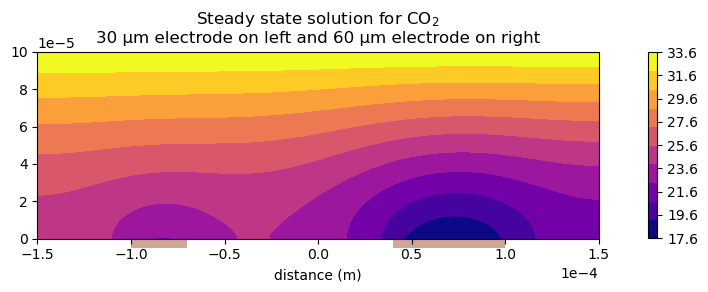

In [7]:
import matplotlib.patches as patches
plt.figure(dpi=100, figsize=(8,6))
plt.title('Steady state solution for CO$_2$\n'
         "30 μm electrode on left and 60 μm electrode on right")
c = plot(cCO2, 
         cmap=plt.cm.get_cmap('plasma', 10))
#c.set_cmap("plasma")
#plot(mesh, linewidth=0.1, zorder=1)
plt.colorbar(c, fraction=0.015, pad=0.08)
plt.gca().ticklabel_format(style='sci', scilimits=(-1,1))
plt.xlabel('distance (m)')
plt.gca().add_patch(patches.Rectangle((-L, -L/20), 30*micron, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))
plt.gca().add_patch(patches.Rectangle((L - 60*micron, -L/20), 60*micron, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))

plt.show()

# Time dependent solution
The PDEs and the boundary conditions

In [8]:
# Duration and time steps
t_final = 20.0                # final time
num_steps = 50                # number of time steps
dt = t_final/num_steps        # time step size, fixed for now

# 1D mesh, evenly spaced
mesh = RectangleMesh(Point(-3*L/2, 0.0), Point(3*L/2, L), 200, 100)  

# Make a function space to hold the 4 scalars which are the solution
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1, P1])
V_hat = FunctionSpace(mesh, element)    # Has subspaces V.sub[0], V.sub[1] etc.

## Set the Dirchlet BCs 
#  Define top boundary.
def top_boundary(x, on_boundary) :
    return on_boundary and near(x[1], L)

# Set values for BCs
bc1 = DirichletBC(V_hat.sub(0), CO2bulk, top_boundary)
bc2 = DirichletBC(V_hat.sub(1), HCO3bulk, top_boundary)
bc3 = DirichletBC(V_hat.sub(2), CO3bulk, top_boundary)
bc4 = DirichletBC(V_hat.sub(3), OHbulk, top_boundary)

BCs = [bc1, bc2, bc3, bc4]

# For the Neumann BCs for the electrodes
#  Options: CO2R electrode in the center of the cell, at the bottom
#           two electrode with a space between them
#           three evenly spaced electrodes, 40 microns in this case
w_elec = 40*micron    
electrode1 = AutoSubDomain(lambda x: near(x[1], 0.0) 
                            and x[0] > -L - w_elec/2 and x[0] < -L + w_elec/2)
electrode2 = AutoSubDomain(lambda x: near(x[1], 0.0) 
                            and x[0] > - w_elec/2 and x[0] < w_elec/2)
electrode3 = AutoSubDomain(lambda x: near(x[1], 0.0) 
                            and x[0] > +L - w_elec/2 and x[0] < +L + w_elec/2)
#right = AutoSubDomain(lambda x: near(x[0], L)) 
# Set the boundaries function to return 1 for electrode 1, 2 for electrode 2, etc. 
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
boundaries.set_all(0)

# These will be used in the weak form 
electrode1.mark(boundaries, 1)
electrode2.mark(boundaries, 2)
electrode3.mark(boundaries, 2)
# Important - need this statement
ds = ds(subdomain_data=boundaries) 

# Set the trial and test functions.
#  need two trial functions
#   one for current time step and
#   one for the next one
u = Function(V_hat)                # Function not TrialFunction for non-linear problems
u_new = Function(V_hat)            # scalar, for the next time step
cCO2, cHCO3, cCO3, cOH = split(u)
cCO2_new, cHCO3_new, cCO3_new, cOH_new = split(u_new)
v1, v2, v3, v4 = TestFunction(V_hat)

# Initial conditions - bulk concentrations throughout domain
u_init = Expression(('CO2bulk','HCO3bulk','CO3bulk','OHbulk'), degree=1,
                   CO2bulk=CO2bulk, HCO3bulk=HCO3bulk, CO3bulk=CO3bulk, OHbulk=OHbulk)

# Start both solution functions with bulk concentratn
u.interpolate(u_init)
u_new.interpolate(u_init)          

# Define variational problem, use indents to isolate the chemistry
#  First line is time and advection (not used here)
#  Second line is diffusion
#  Third line is chemistry - written as a negative term
#                           inside parens sinks are negative, sources are positive
#  Fourth line is spatial source terms (not used here) and Neumann BCs for each electrode

R1 = ((cCO2 - cCO2_new)/dt)*v1*dx   \
     + DCO2*dot(grad(cCO2), grad(v1))*dx \
     - (-k1f*cCO2*cOH + k1r*cHCO3)*v1*dx \
     - CO2_molar_flux*v1*ds(1) - CO2_molar_flux*v1*ds(2) - CO2_molar_flux*v1*ds(3)
     
R2 = ((cHCO3 - cHCO3_new)/dt)*v2*dx   \
     + DHCO3*dot(grad(cHCO3), grad(v2))*dx \
     - (+k1f*cCO2*cOH - k1r*cHCO3 - k2f*cHCO3*cOH + k2r*cCO3)*v2*dx 

R3 = ((cCO3 - cCO3_new)/dt)*v3*dx   \
     + DCO3*dot(grad(cCO3), grad(v3))*dx \
     - (+k2f*cHCO3*cOH - k2r*cCO3)*v3*dx 

R4 = ((cOH - cOH_new)/dt)*v4*dx   \
     + DOH*dot(grad(cOH), grad(v4))*dx \
     - (-k1f*cCO2*cOH + k1r*cHCO3 - k2f*cHCO3*cOH + k2r*cCO3)*v4*dx \
     - OH_molar_flux*v4*ds(1) - OH_molar_flux*v4*ds(2) - OH_molar_flux*v4*ds(3)
     
Eqs = R1 + R2 + R3 + R4   # Add them together for the coupled problem

In [9]:
# Interate to compute solution
t = 0
num_steps = int(t_final/dt)

# writing pvd file works but it writes a lot of .vtu files
# Can figure out later how to do this with a single xdmf file, this should be possible
#file = File("FEniCS animations/Diffusion layer evolution.pvd", "compressed")
#file << (u_new.split()[0], t)
for n in range(num_steps):
    # Update current time
    t += dt                    # Update time
    solve(Eqs == 0, u, BCs, 
          solver_parameters={"newton_solver":           # Sent instructions to the Newton solver
                        {"relative_tolerance": 1e-6}})  # Default toleracne is 1e-9
    u_new.assign(u)                                      # Update for next step and append vertex values to np.array
    #file << (u_new.split()[0], t)
    
# Post-processing to get pH
V = FunctionSpace(mesh, "CG", 1)   # make a simple space for pH

# It took a while to figure out the correct nomenclature
pH_new = interpolate(Expression("log10(u/molar)+14", 
                                degree=1, u=u_new.sub(3), molar=molar), V)

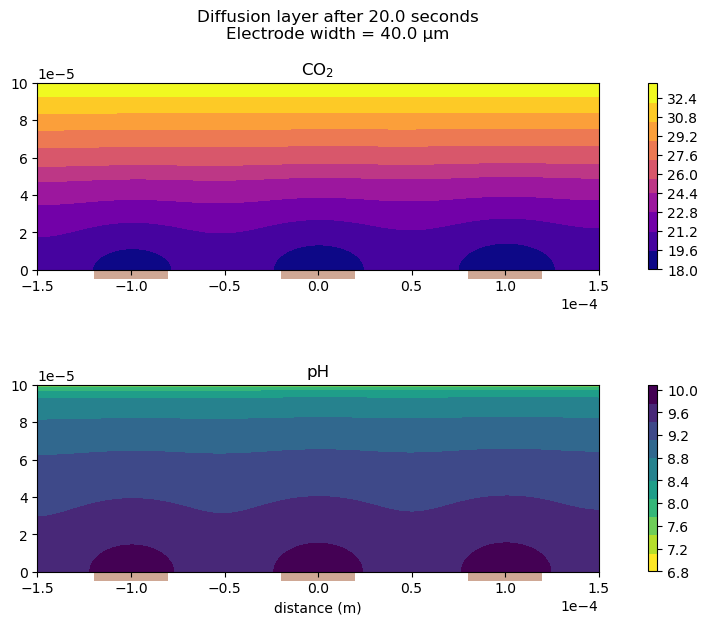

In [10]:
# Visualize solution
import matplotlib.patches as patches

plt.figure(dpi=100, figsize=(8,8))
plt.suptitle(f'Diffusion layer after {t_final:.1f} seconds\n'
             f'Electrode width = {w_elec/micron:.1f} μm', y=0.90)
plt.subplot(2,1,1)
plt.title('CO$_2$')
c = plot(cCO2_new, 
         cmap=plt.cm.get_cmap('plasma', 10))
#c.set_cmap("plasma")
#plot(mesh, linewidth=0.1, zorder=1)
plt.colorbar(c, fraction=0.015, pad=0.08)
plt.gca().ticklabel_format(style='sci', scilimits=(-1,1))
plt.gca().add_patch(patches.Rectangle((-L - w_elec/2, -L/20), w_elec, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))
plt.gca().add_patch(patches.Rectangle((0 - w_elec/2, -L/20), w_elec, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))
plt.gca().add_patch(patches.Rectangle((L - w_elec/2, -L/20), w_elec, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))
plt.subplot(2,1,2)
plt.title('pH')
c = plot(pH_new, 
         cmap=plt.cm.get_cmap('viridis_r', 10))
#c.set_cmap("plasma")
#plot(mesh, linewidth=0.1, zorder=1)
plt.colorbar(c, fraction=0.015, pad=0.08)
plt.gca().ticklabel_format(style='sci', scilimits=(-1,1))
plt.xlabel('distance (m)')
plt.gca().add_patch(patches.Rectangle((-L - w_elec/2, -L/20), w_elec, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))
plt.gca().add_patch(patches.Rectangle((0 - w_elec/2, -L/20), w_elec, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))
plt.gca().add_patch(patches.Rectangle((L - w_elec/2, -L/20), w_elec, L/20,
                               facecolor='sienna', clip_on=False, alpha=0.5))

plt.subplots_adjust(hspace=0.0)
plt.show()

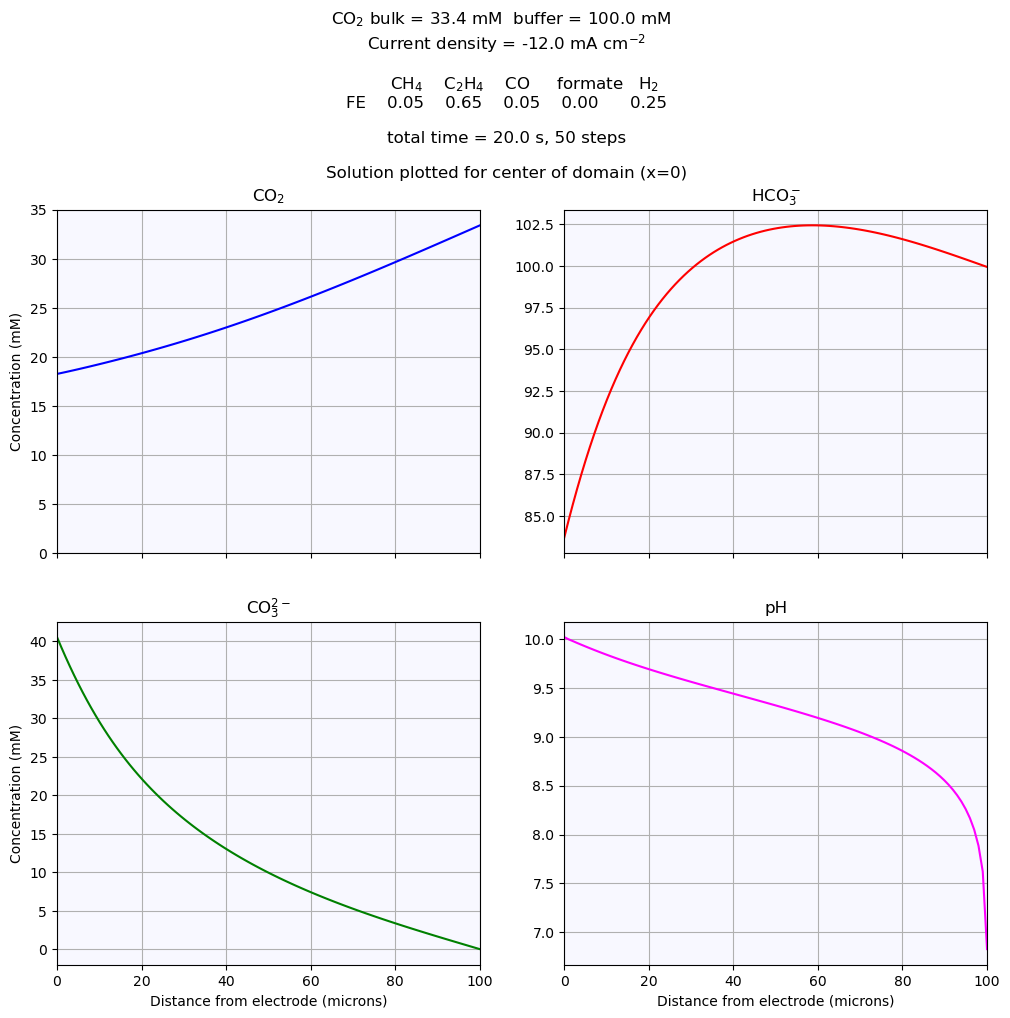

In [11]:
# Visualize along the center line
y_grid = np.linspace(0, L, 100)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10), dpi=100, sharex=True, sharey=False) 
fig.suptitle(f'CO$_2$ bulk = {CO2bulk/mM:3.1f} mM  buffer = {buffer/mM:3.1f} mM   '
             f'\nCurrent density = {jTotal/(mA*cm**-2):3.1f} mA cm$^{{-2}}$\n\n'
            '       CH$_4$    C$_2$H$_4$    CO     formate   H$_2$ \n' 
            f'FE    {FEmethane:3.2f}    {FEethylene:3.2f}    {FECO:3.2f}    {FEformate:3.2f}      {FEH2:3.2f}\n'
             f'\ntotal time = {t_final} s, {num_steps} steps\n\n'
             'Solution plotted for center of domain (x=0)',
            fontsize=12, y=1.08)
ax1.set_title('CO$_2$'); ax2.set_title('HCO$_3^-$'); ax3.set_title('CO$_3^{2-}$'); ax4.set_title('pH')

# Had to reach bock into the solution, the parts split from the solution did not work
ax1.plot(y_grid/micron, 
         [u_new.sub(0)(0, y)/mM for y in y_grid], 'b') 
ax2.plot(y_grid/micron, 
         [u_new.sub(1)(0, y)/mM for y in y_grid], 'r')
ax3.plot(y_grid/micron, 
         [u_new.sub(2)(0, y)/mM for y in y_grid], 'g') 
ax4.plot(y_grid/micron, 
         [pH_new(0, y) for y in y_grid], 'magenta') 
  
ax1.set_xlim(0,100)
ax1.set_ylim(0,35)

ax3.set_xlabel('Distance from electrode (microns)')
ax4.set_xlabel('Distance from electrode (microns)')
ax1.set_ylabel('Concentration (mM)')
ax3.set_ylabel('Concentration (mM)')
ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid(); 

ax1.set_facecolor('ghostwhite'); ax2.set_facecolor('ghostwhite')
ax3.set_facecolor('ghostwhite'); ax4.set_facecolor('ghostwhite')

plt.show() 